# Synthetic Control - parameter recovery

This notebook shows an example of running Bayesian synthetic control on some synthetic data.

In [1]:
from causal_impact.causal_impact import SyntheticControl
from causal_impact.simulate_data import generate_synthetic_control_data

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [4]:
%load_ext autoreload
%autoreload 2

## Generate simulated dataset

In [5]:
treatment_time = 70
df, weightings_true = generate_synthetic_control_data(treatment_time=treatment_time)
df.head()

,a,b,c,d,e,f,g,counterfactual,causal effect,actual
0,1.436118,-1.533909,1.219879,2.938360,-2.731432,-1.242916,-0.097454,-0.248790,-0.0,-0.256073
1,1.294627,-0.965060,1.480310,3.394190,-2.221168,-0.648572,0.266645,0.187205,-0.0,0.220217
2,2.560838,0.791222,2.198622,3.874395,-1.389850,-1.443345,0.932944,0.618875,-0.0,0.784554
3,2.633924,1.046636,2.264461,3.732258,-1.157615,-1.484965,1.240342,1.045527,-0.0,1.019727
4,3.076161,2.390208,2.080667,3.837581,0.283480,-1.497101,1.472687,1.466702,-0.0,1.737391


Create some useful visualisations

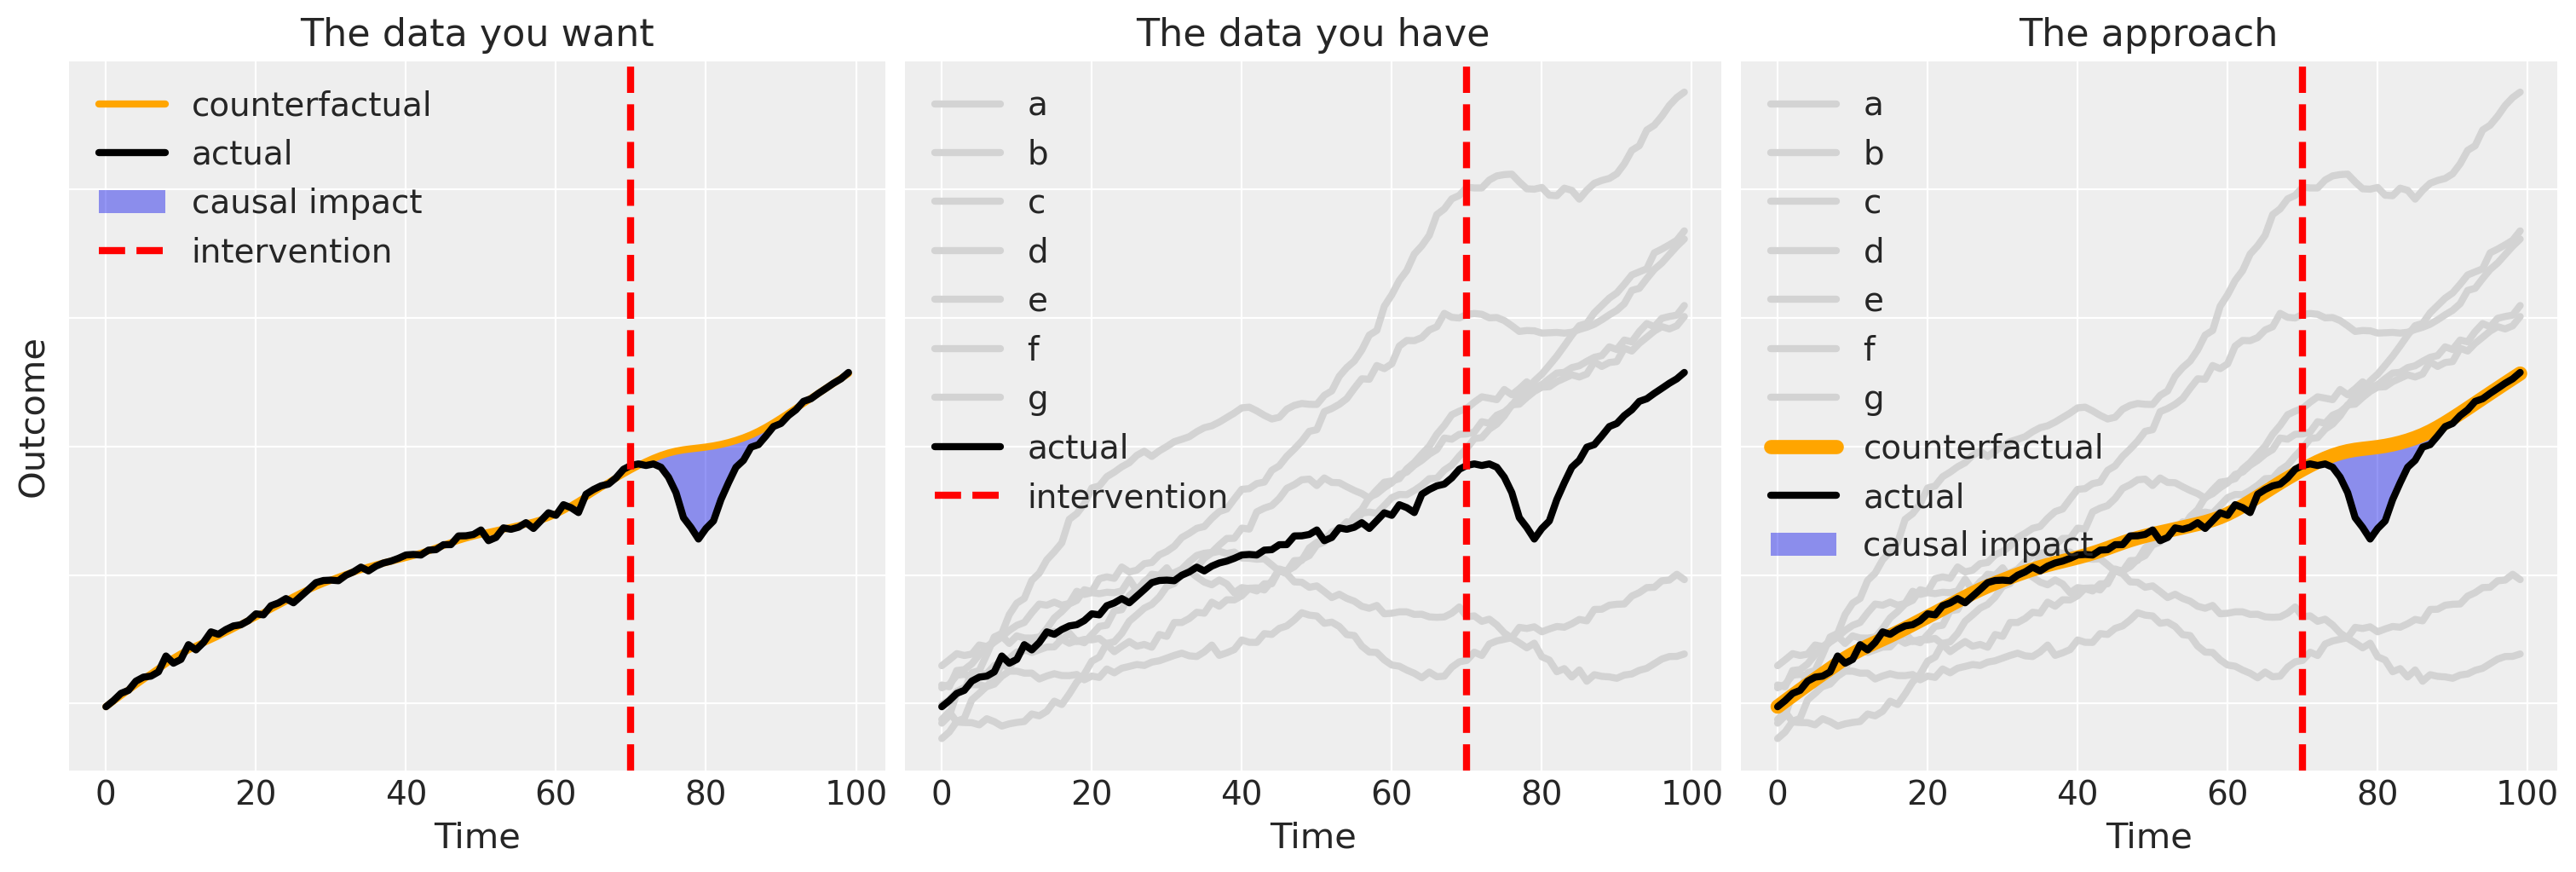

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# WHAT YOU WANT
df.loc[:, ['counterfactual']].plot(c='orange', lw=3, ls="-", ax=ax[0])
df.loc[:, ['actual']].plot(c='k', ax=ax[0], lw=3)
ax[0].fill_between(df.index, df['counterfactual'], df['actual'], alpha=0.5, label='causal impact')
ax[0].set(xlabel="Time", ylabel="Outcome", yticklabels=[], title='The data you want')
ax[0].axvline(x=treatment_time, linewidth=3, c='r', ls='--', label='intervention')
ax[0].legend()

# WHAT YOU HAVE
df.loc[:, ['a', 'b', 'c', 'd', 'e', 'f', 'g']].plot(c='lightgrey', lw=3, ax=ax[1])
df.loc[:, ['actual']].plot(c='k', ax=ax[1], lw=3)
ax[1].set(xlabel="Time", ylabel="Outcome", yticklabels=[], title='The data you have')
ax[1].axvline(x=treatment_time, linewidth=3, c='r', ls='--', label='intervention',)
ax[1].legend();

# THE APPROACH
df.loc[:, ['a', 'b', 'c', 'd', 'e', 'f', 'g']].plot(c='lightgrey', lw=3, ax=ax[2])
df.loc[:, ['counterfactual']].plot(c='orange', ax=ax[2], lw=6, ls="-")
df.loc[:, ['actual']].plot(c='k', ax=ax[2], lw=3)
ax[2].fill_between(df.index, df['counterfactual'], df['actual'], alpha=0.5, label='causal impact')
ax[2].set(xlabel="Time", ylabel="Outcome", yticklabels=[], title='The approach')
ax[2].axvline(x=treatment_time, linewidth=3, c='r', ls='--')
ax[2].legend();

## Bayesian synthetic control

See if we can infer the causal impact accurately by estimating a synthetic control

In [7]:
result = SyntheticControl(df, 
                          treatment_date=treatment_time, 
                          target_var="actual",
                          predictor_vars=['a', 'b', 'c', 'd', 'e', 'f', 'g'])

PRIOR PREDICTIVE CHECK
INFERENCE


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 136 seconds.


POSTERIOR PREDICTIVE CHECK


COUNTERFACTUAL INFERENCE


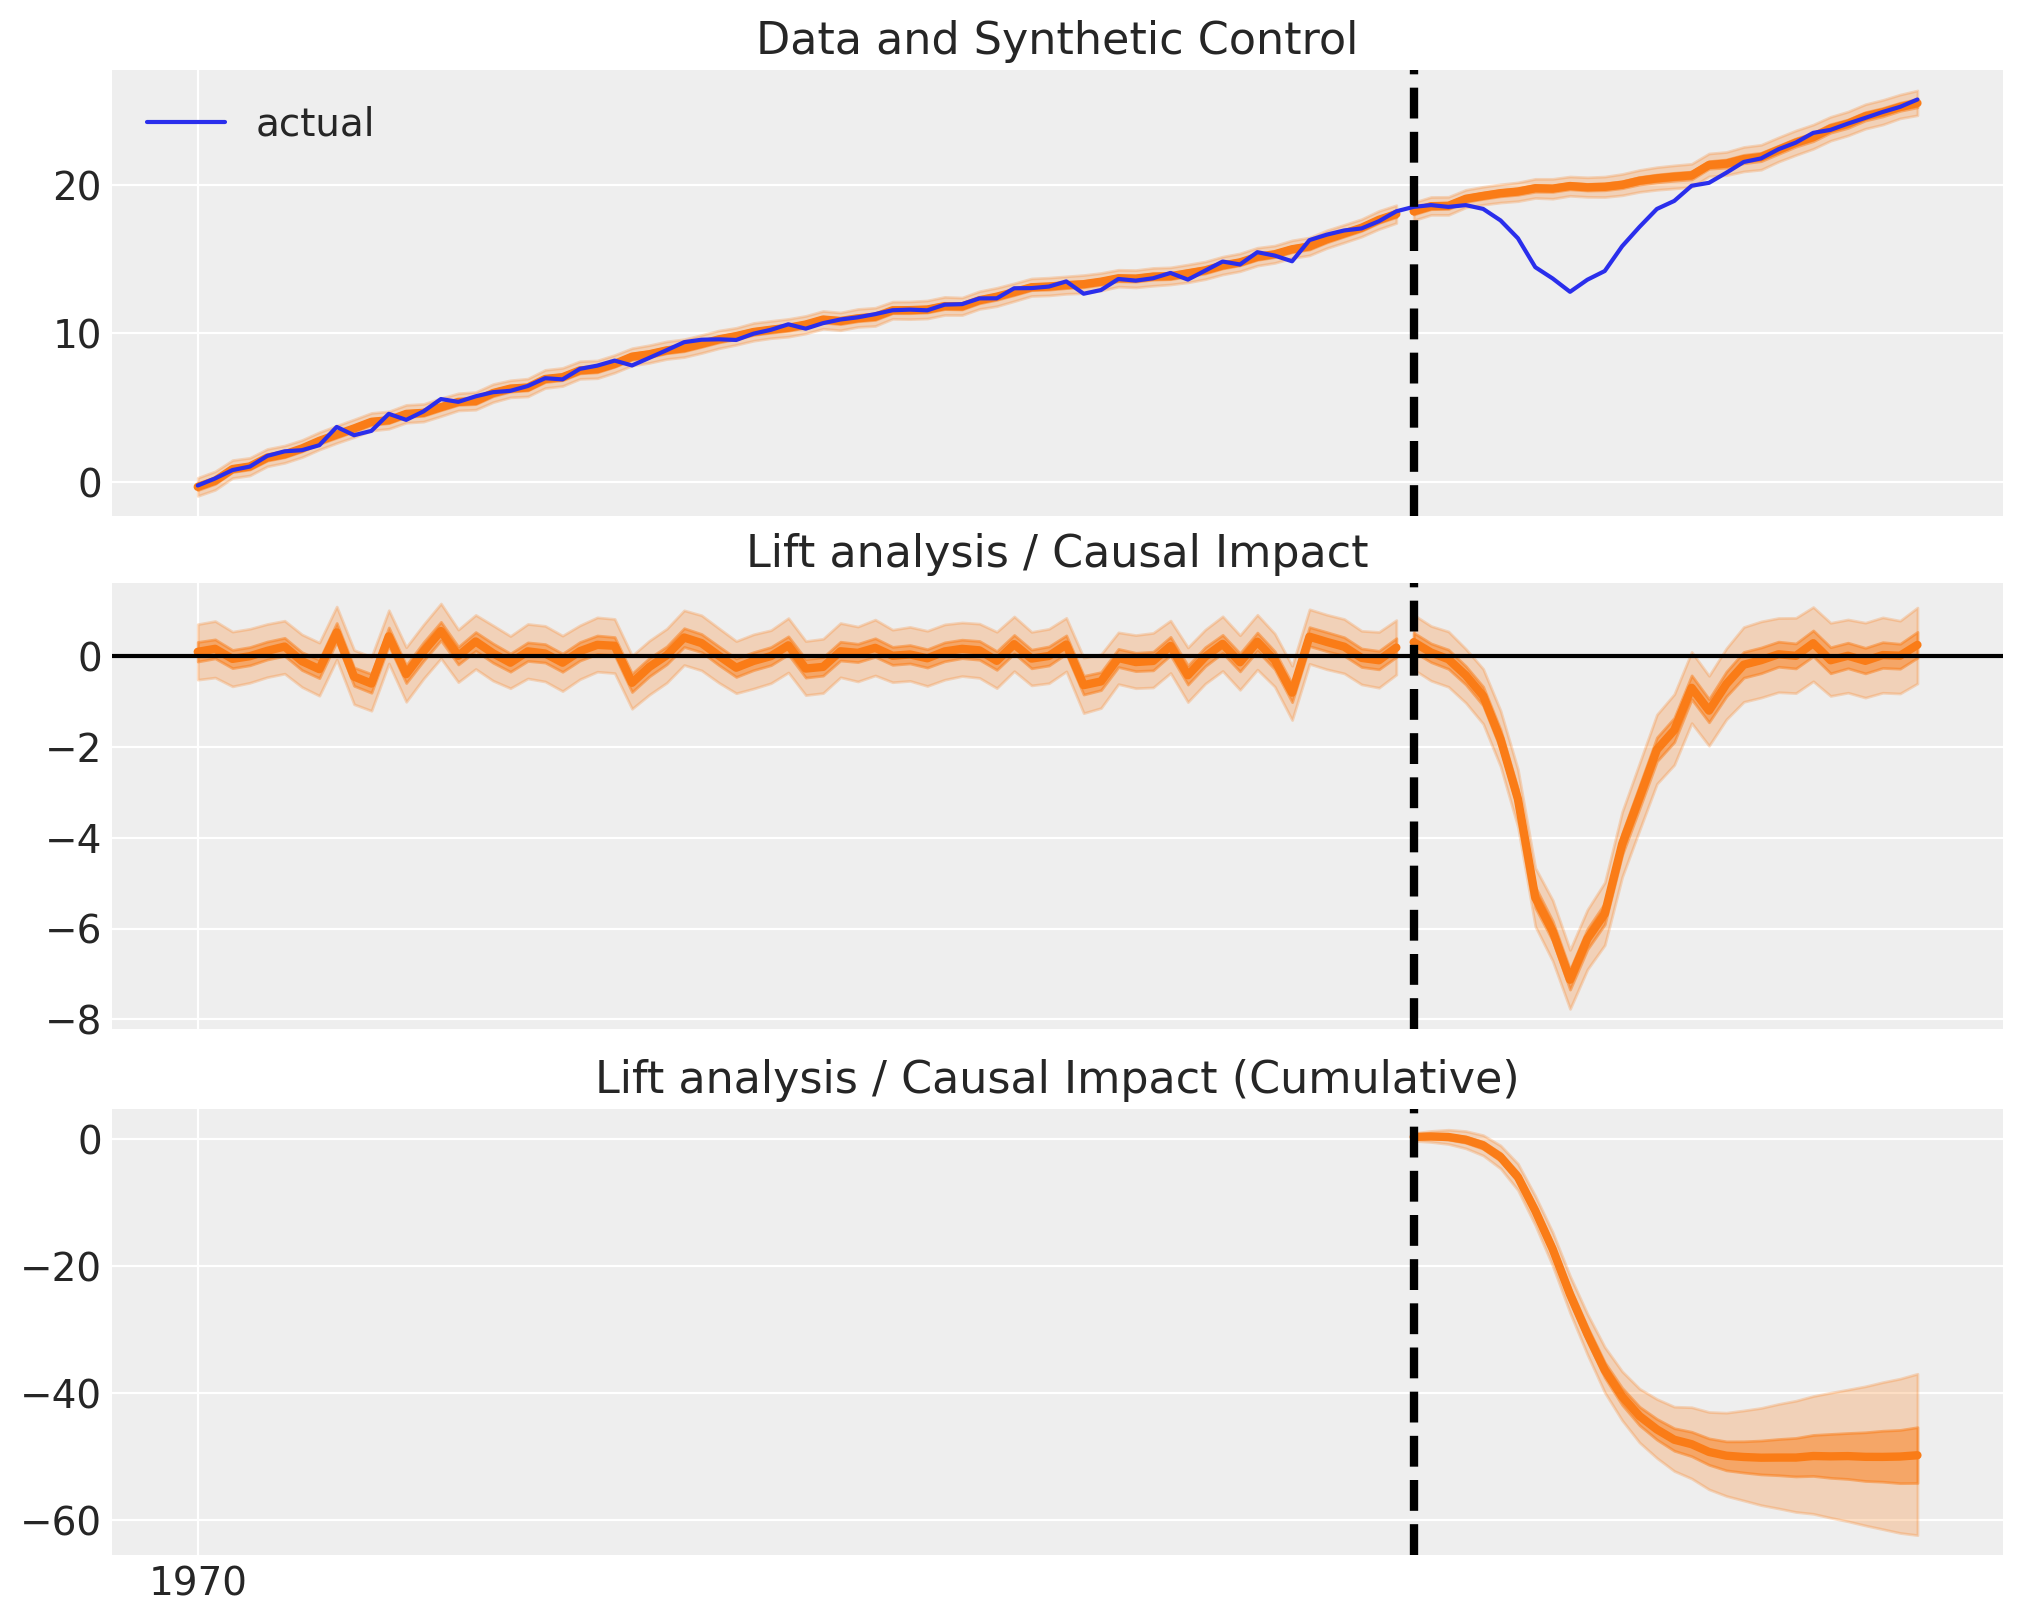

In [8]:
result.plot()

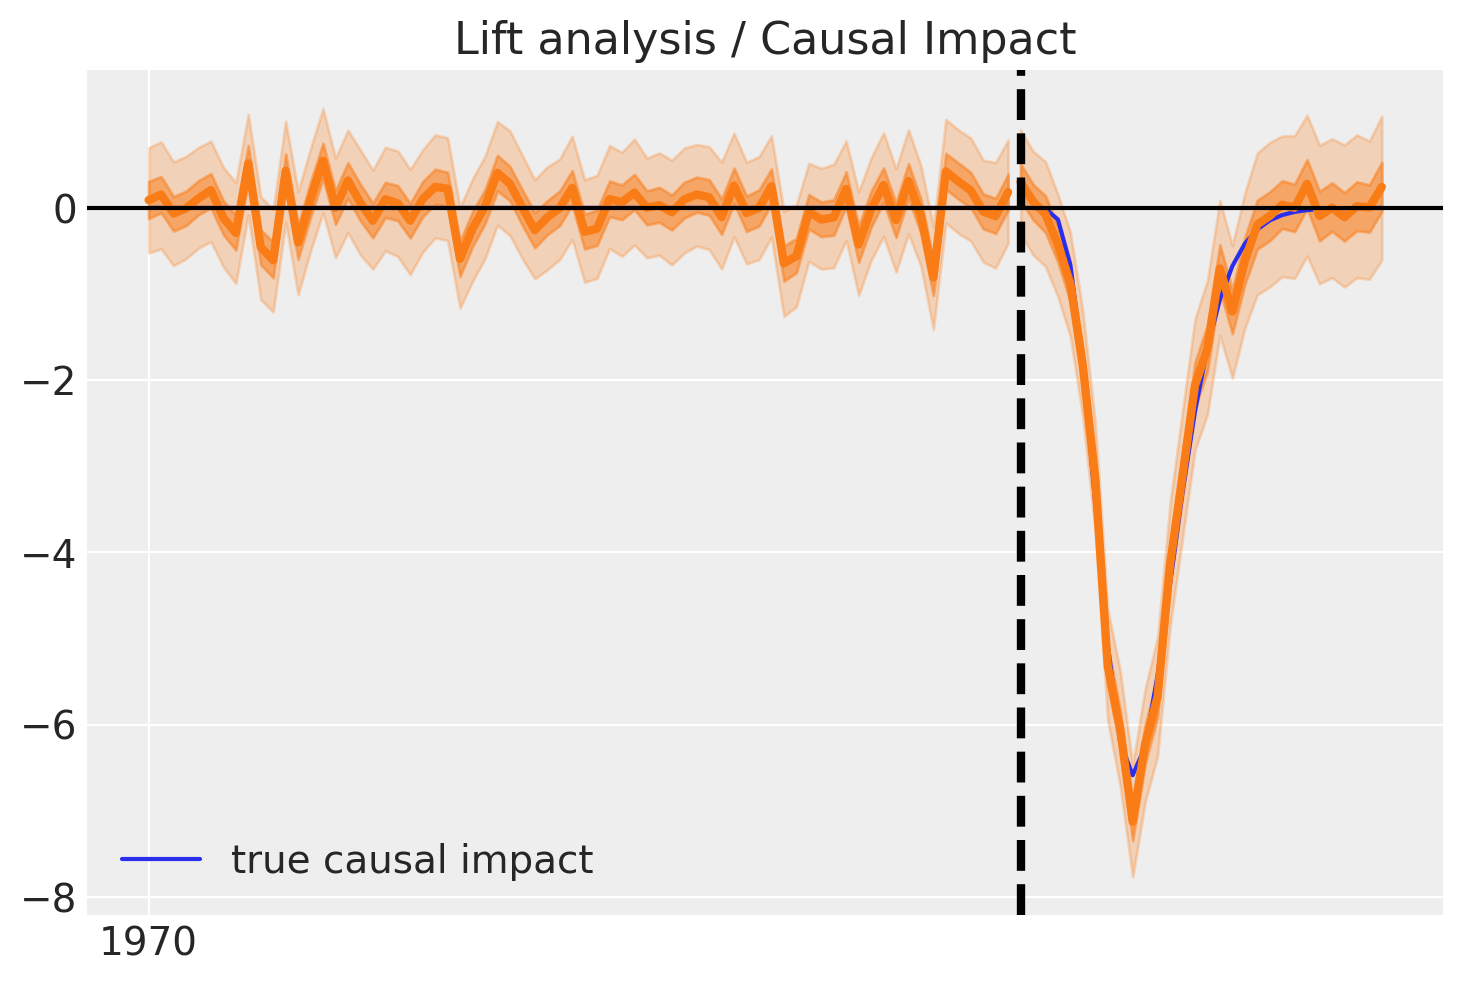

In [9]:
fig, ax = plt.subplots()
ax.plot(df['causal effect'], label='true causal impact')
result.plot_causal_impact(ax=ax)
ax.legend();

Visualise the posterior distributions of the variable weightings.

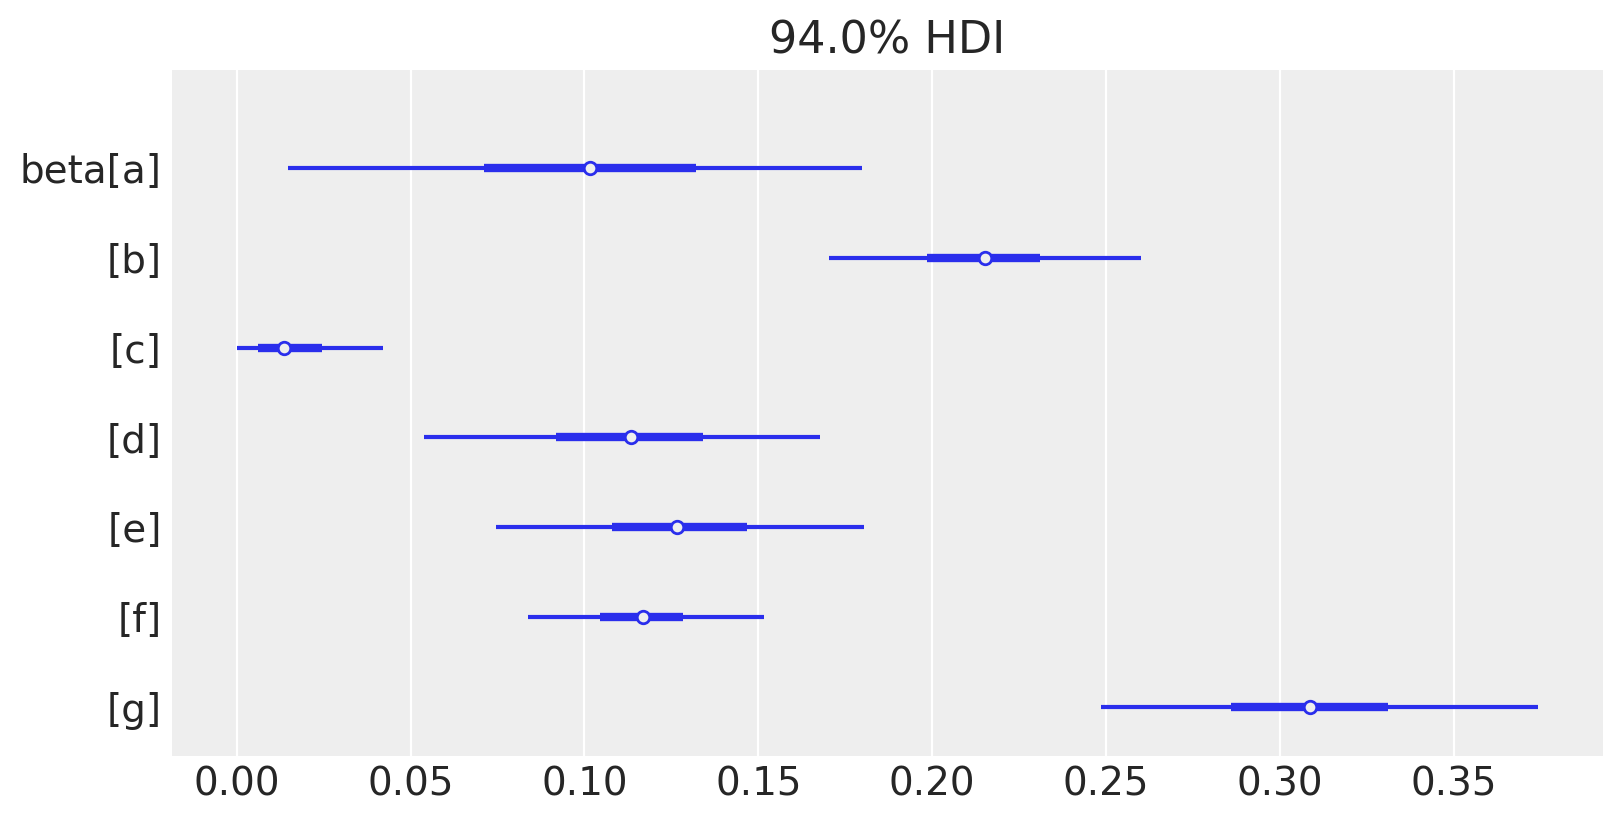

In [10]:
az.plot_forest(result.idata_pre.posterior, var_names="beta", figsize=(8, 4), combined=True);

A similar plot of the posterior distributions of variable weightings, but this time with ground truth of the simulated data.

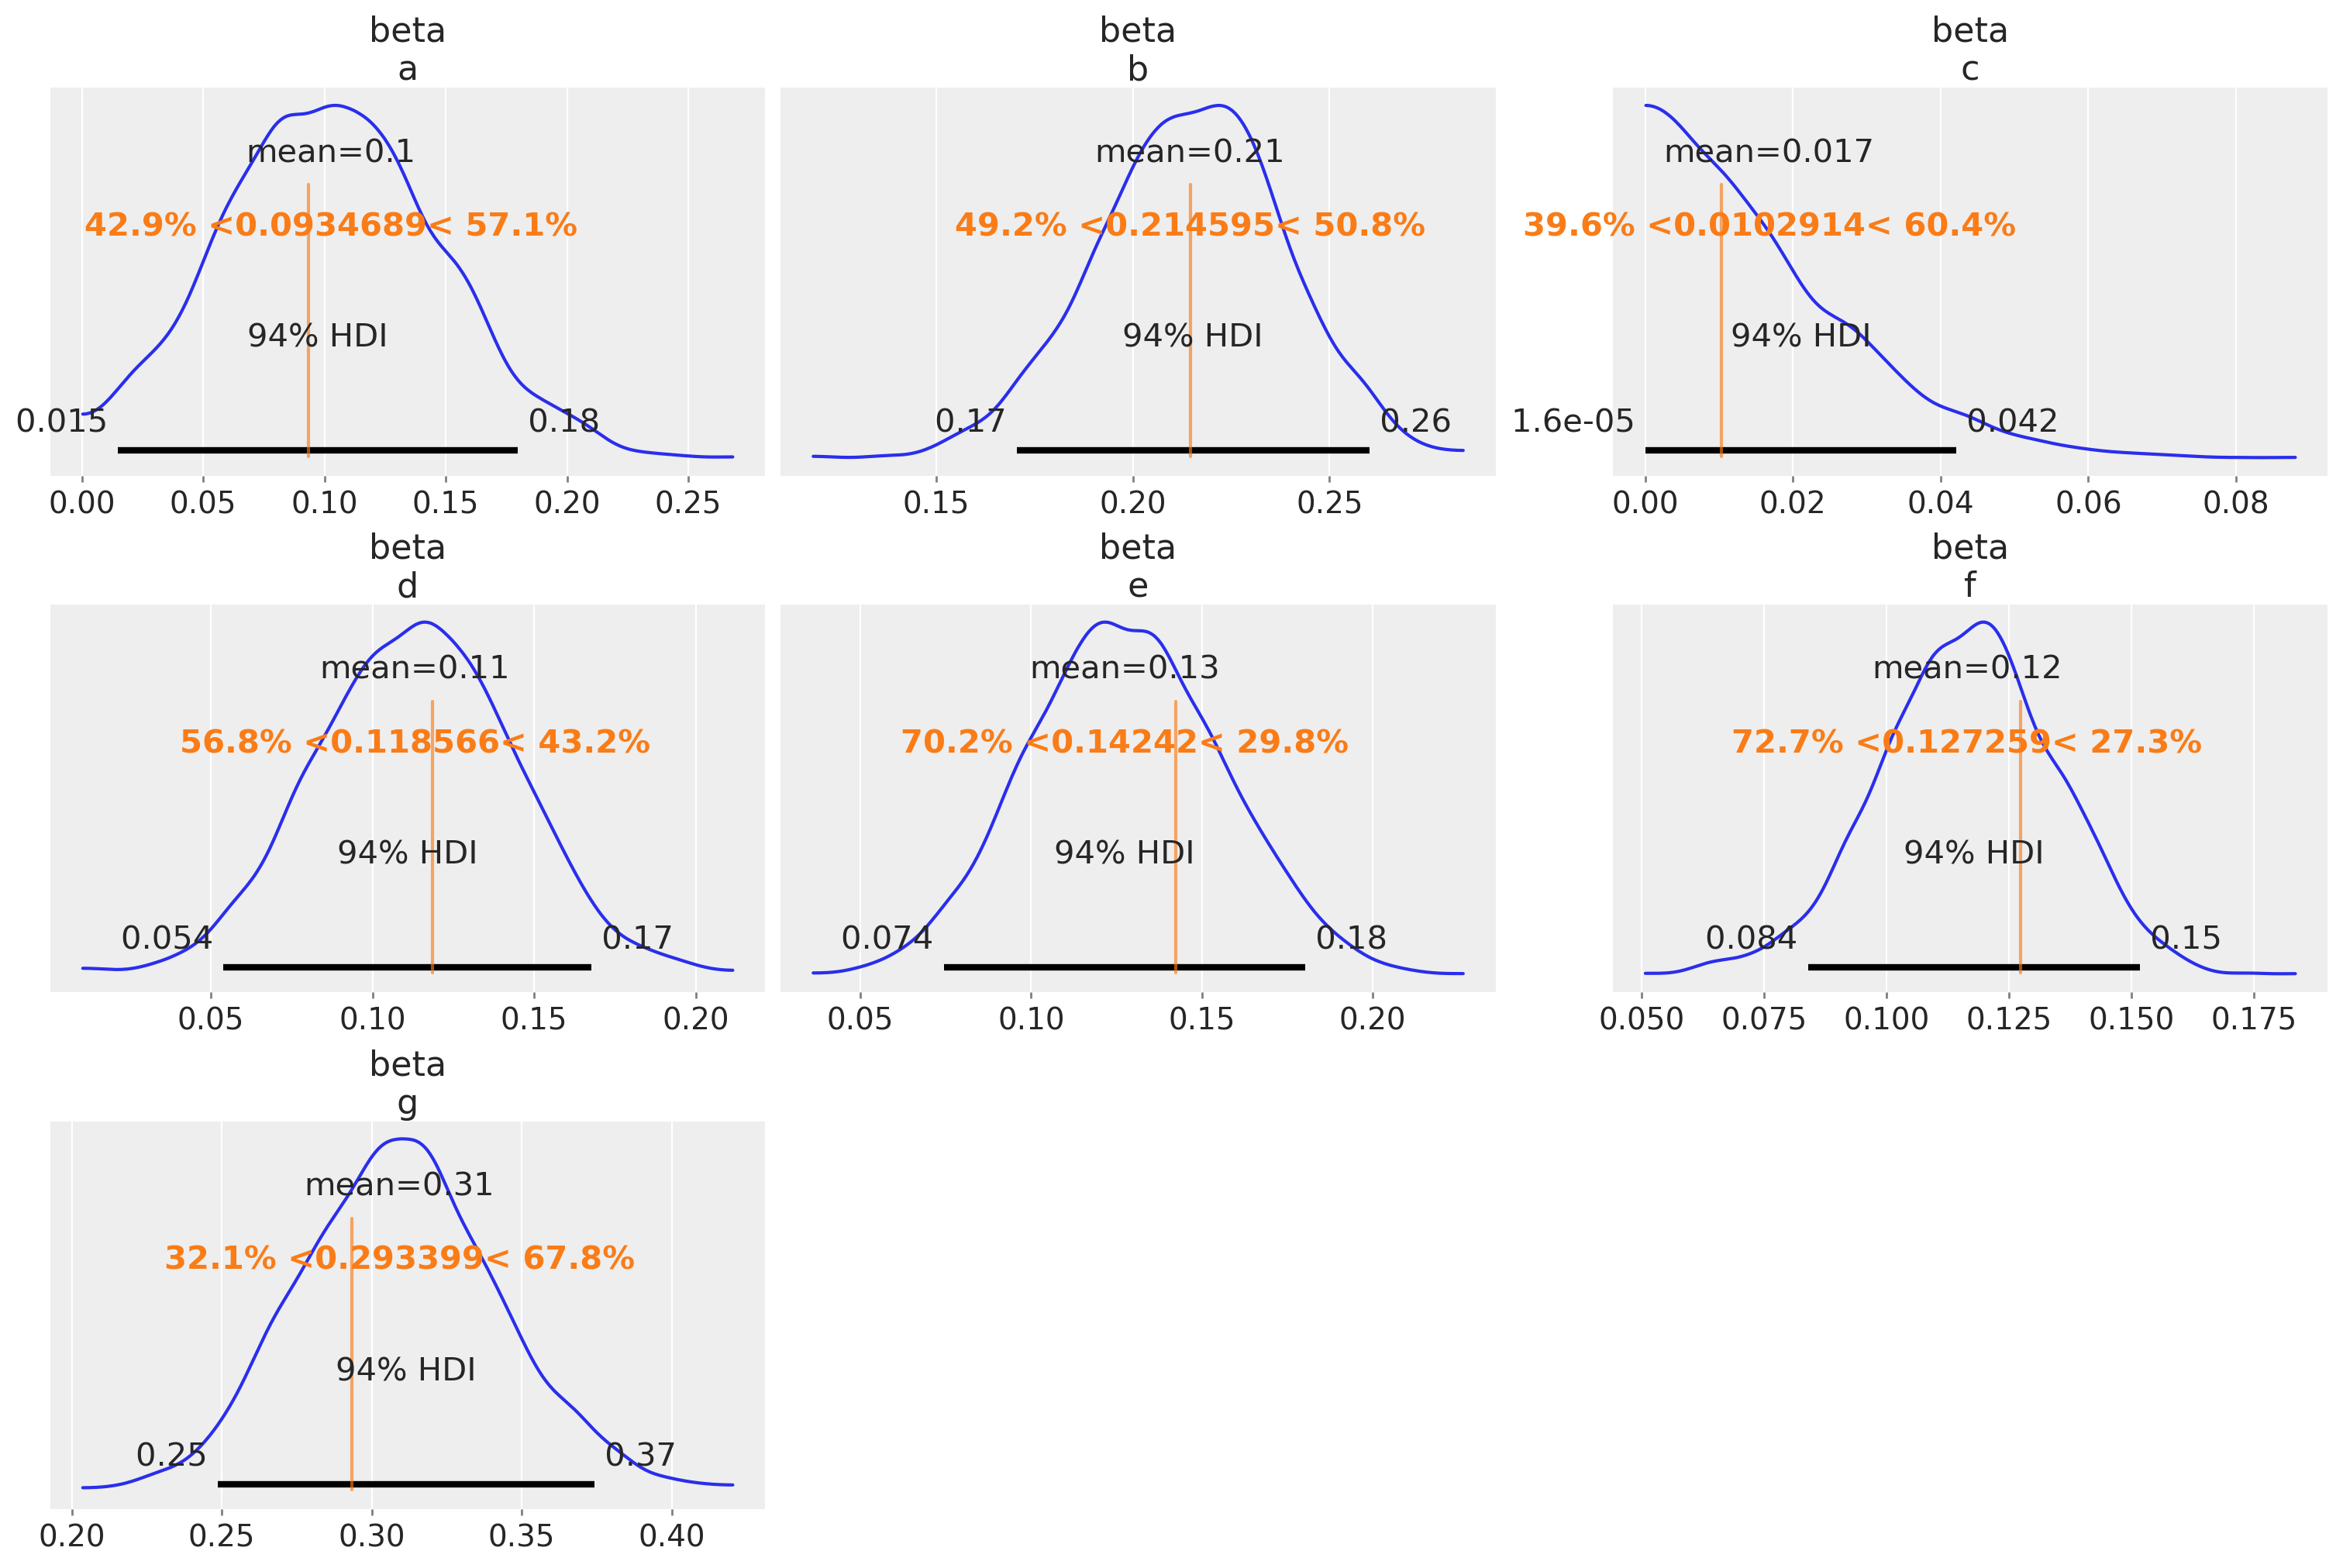

In [11]:
ref_val = {"beta": [{"predictors": "a", "ref_val": weightings_true[0][0]},
                    {"predictors": "b", "ref_val": weightings_true[0][1]},
                    {"predictors": "c", "ref_val": weightings_true[0][2]},
                    {"predictors": "d", "ref_val": weightings_true[0][3]},
                    {"predictors": "e", "ref_val": weightings_true[0][4]},
                    {"predictors": "f", "ref_val": weightings_true[0][5]},
                    {"predictors": "g", "ref_val": weightings_true[0][6]}]}

az.plot_posterior(result.idata_pre.posterior['beta'], ref_val=ref_val, figsize=(15, 10));